In [373]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [374]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# import data directly from google sheets

In [375]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
spreadsheet = gc.open_by_key('1bfPrp0w8Ruorq08Qe4hD8M3xVJ5e00phZ6ApFivO98k') # dec 2022 version

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [376]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [377]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [378]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [379]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [380]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [381]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# projects by country, by region

In [382]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_country_df[status] = country_ratios_gas_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


# numbers of pipes finished in a given year

In [383]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [384]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Gas')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [385]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Gas')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [386]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [387]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [388]:
pipes_indev_startyear.unstack()

StartYearEarliest,"2,018.0","2,019.0","2,020.0","2,021.0","2,022.0","2,023.0","2,024.0","2,025.0","2,026.0","2,027.0","2,028.0","2,029.0","2,030.0","2,034.0","2,035.0","2,046.0",NaN
Status,,,,,,,,,,,,,,,,,
Construction,873.0,NaN,NaN,50.0,"22,060.0","12,793.6","5,394.2","1,982.1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"16,146.8"
Proposed,NaN,450.0,670.3,209.0,"8,827.6","10,458.6","11,206.2","10,185.3","3,609.2","3,576.7","5,323.7",942.0,"5,855.6",315.0,110.0,"5,660.0","83,933.5"
Shelved,NaN,221.7,"1,100.7","5,448.6","3,588.4","3,353.4","1,308.4","1,170.0",NaN,150.0,11.0,135.0,NaN,NaN,NaN,NaN,"21,242.0"


## Fig 2 - 2023–2030, go back to 2008

In [389]:
pandas.DataFrame(pipes_started_sum).to_excel('saved-tables/pipelines-operating-km-by-start-year.xlsx')

pandas.DataFrame(pipes_indev_startyear).unstack().replace(numpy.nan,0).to_excel('saved-tables/pipelines-indev-km-by-start-year.xlsx')

## future/past plot

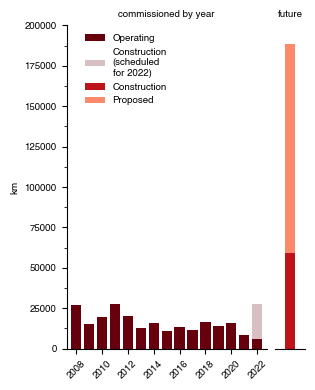

In [390]:
font_size = 7

ytop = 200000
ytop2 = 200000
xlo=2008
xhi=2022

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.loc[range(xlo,xhi+1)].index.values, pipes_started_sum.loc[range(xlo,xhi+1)].values,
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(xlo-0.75, xhi+0.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []
# for x,c,s in zip(xvals,colors,status):
#     if s in ['Proposed','Shelved']:
#         ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
#                  color=c, label=s))
#     else:
#         ax2_list.append(ax2.bar(x, pipes_indev[s],
#                  color=c, label=s))
ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2022],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0.5)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022-alt.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022-alt.pdf', bbox_inches='tight', transparent=True)

In [391]:
pipes_indev

Status
Construction    59,299.7
Proposed       151,332.6
Shelved         37,729.3
Name: LengthMergedKm, dtype: object

## percent pipelines with start date (sanity check)

In [392]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [393]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.543646408839779

## regional pipelines started in given year

In [394]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [395]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [396]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

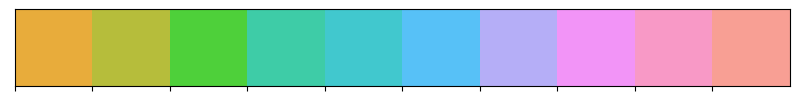

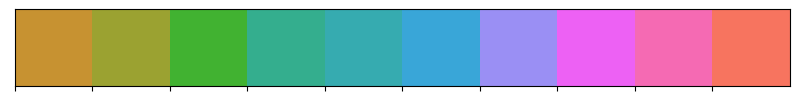

In [397]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

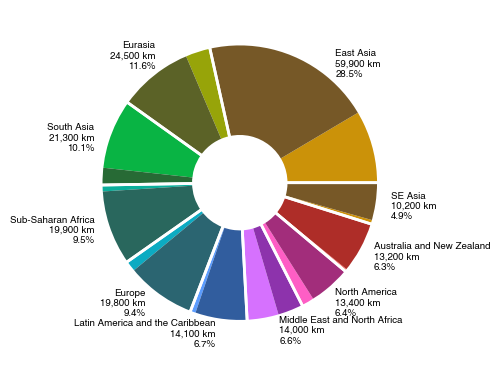

In [398]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/gas-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/gas-pipelines_pie-graph-country-pipelines-km.png', 
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

# top 20 countries proposed+construction

In [399]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

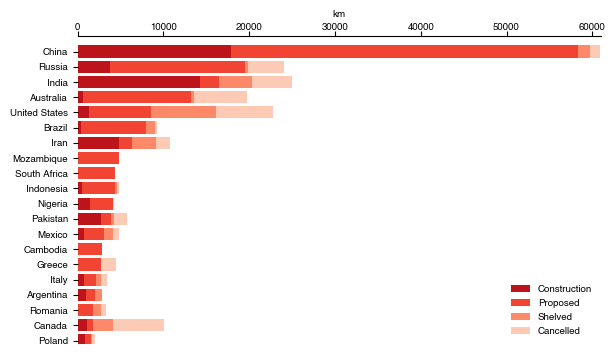

In [400]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,61000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/gas-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/gas-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

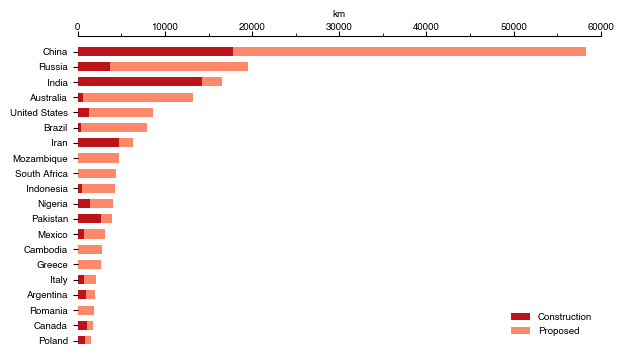

In [401]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/gas-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/gas-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [402]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.5336787156529343

# parent analysis

In [403]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['Proposed','Construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

## print out leading parent companies

In [404]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

parent_country_km_df_table['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [405]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (Proposed + Construction)'] = parent_country_km_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]

,Pipeline Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs,Number of Projects
Gazprom,"Russia, Mongolia, China, Bulgaria, Serbia, Iran, Pakistan, Kazakhstan, Kyrgyzstan",Russia,"16,497.8","3,728.9","20,226.6","P0734, P1336, P2287, P2313, P2327, P2346, P2353, P2425, P2437, P2707, P3174, P3176, P3208, P3369, P3370, P3604, P3607, P3725, P3894, P3895, P3971, P3972, P3973, P3974, P3976, P3977, P3978, P3979, P3980, P3981, P3982, P3990, P3991, P3992, P3996, P3997, P3998, P3999, P4012, P4013, P4044, P4056, P4063, P4076, P4077, P4078, P4080, P4081, P4083, P4085, P4092, P4093, P4094, P4095, P4096, P4109, P4110, P4111, P4112, P4130, P4131, P4132, P4142, P4143, P4144, P4149, P4150, P4156, P4166, P4167, P4171,...",82
"National Petroleum and Natural Gas Pipeline Network Group Co., Ltd.","China, North Korea",China,"12,677.7","5,791.8","18,469.5","P4495, P4513, P4526, P4556, P4557, P4558, P4561, P4579, P4605, P4622, P4644, P4651, P4659, P4660, P4661, P4662, P4663, P4664, P4665, P4666, P4687, P4688, P4689, P4690, P4697, P4698, P4700, P4701, P4702, P4703, P4704, P4705, P4707, P4708, P4709, P4711, P4716, P4722, P4723, P4747, P4749, P4750, P4751, P4752, P4753, P4775, P4784, P4785, P4786, P4787, P4790, P4791, P4792, P4835, P4836, P4840, P4842, P4843, P4844, P4852, P4854, P4855, P4868, P4871, P4875, P4881, P4882, P4884, P4885, P4890, P4895,...",101
GAIL (India) Limited,India,India,890.0,"6,821.5","7,711.5","P0929, P0932, P0954, P1309, P2215, P2216, P2746, P2752, P3906, P3912",10
Nigerian National Petroleum Corporation,"Nigeria, Algeria, Niger, Senegal, Joint regime area (Senegal/Guinea Bissau), Spain, Ghana, The Gambia, Liberia, Morocco, Sierra Leone, Western Sahara, Côte d'Ivoire, Mauritania, Guinea-Bissau, Guinea",Nigeria,"4,927.6","1,427.0","6,354.6","P0460, P0463, P0488, P1313, P4185",20
Iran Ministry of Petroleum,"Iran, Pakistan, Oman",Iran,400.0,"5,875.0","6,275.0","P0441, P0448, P0452, P2225",6
Transnet,"Namibia, South Africa",South Africa,"3,949.2",,"3,949.2","P2254, P2469, P2470, P2471, P2472, P2473, P2474, P3337, P3338, P3339",11
"Anhui Province Natural Gas Development Co., Ltd.",China,,"1,653.6","1,594.0","3,247.6","P4580, P4581, P4582, P4583, P4584, P4585, P4586, P4587, P4589, P4591, P4592, P4593, P4594, P4596, P4597, P4598, P4600, P4603",18
TC Energy,"Canada, Mexico, United States",Canada,"1,364.6","1,512.8","2,877.4","P0167, P0331, P0434, P1268, P2004, P2005, P2501, P2530, P2556, P2569, P2743, P3186, P3187, P3188, P3189, P3276, P3277, P3279, P3608, P3609, P3610, P3611, P3612, P3613, P3615, P3618, P3639, P3640, P3641, P3921, P4446, P4447",32
Moroccan National Board of Hydrocarbons and Mines,"Senegal, Joint regime area (Senegal/Guinea Bissau), Spain, Ghana, The Gambia, Liberia, Morocco, Sierra Leone, Western Sahara, Côte d'Ivoire, Mauritania, Guinea-Bissau, Guinea",Morocco,"2,865.6",,"2,865.6",P0463,14
Turkmengaz,"Turkmenistan, Azerbaijan, Pakistan, India, Afghanistan, Uzbekistan, Kyrgyzstan, Tajikistan, China",Turkmenistan,270.0,"2,136.1","2,406.1","P0764, P0766, P2030, P3915",13


### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [406]:
# kuhne paper
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

### total emissions globally (known capacity is at about 67%)

### count fraction of available capacity information

count

In [407]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Australia and New Zealand           23
East Asia                          166
Eurasia                             62
Europe                              58
Latin America and the Caribbean     30
Middle East and North Africa        10
North America                      103
SE Asia                             11
South Asia                          29
Sub-Saharan Africa                   6
Name: CapacityBOEd, dtype: int64

fraction

In [408]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
Latin America and the Caribbean,0.938
Australia and New Zealand,0.821
North America,0.730
South Asia,0.725
Eurasia,0.667
East Asia,0.582
Middle East and North Africa,0.476
Europe,0.408
SE Asia,0.407


In [409]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()

In [410]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()).median()

In [411]:
pipes_df_orig['CapacityBcm/y'].mean()

233.5703213317847

In [412]:
pipes_df_orig['CapacityBcm/y'].std()

618.7168037143194

In [413]:
print(median_capacity)
print(abs_dist_from_med_capacity)

3.79
3.27


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

## pick out high and low quantiles

In [414]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Gas')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

175781.616
17872801.85399996


In [415]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Gas') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                    #(country_ratios_df['LengthKnownKm']!=0) &
                                    #(country_ratios_df['CostUSDPerKm']<10e6)
                                   ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [416]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2904756.052615063

### calculate regional costs

In [417]:
pipes_gas_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_gas_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_gas_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()


Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


In [418]:
country_ratios_region_df['CostUSDPerKm'].mean()

3928708.954117647

In [419]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_gas_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
North America,4.875,147
Eurasia,4.043,41
Sub-Saharan Africa,3.929,5
Latin America and the Caribbean,3.637,23
Europe,2.922,111
Middle East and North Africa,2.891,37
SE Asia,2.703,7
South Asia,1.956,15
East Asia,1.442,120
Australia and New Zealand,1.441,9


### calculate country-level costs

# tables etc.

## table for regional totals

In [420]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_96472/997741405.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_region_df = km_by_region_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,"42,022.300","17,898.960","59,921.260","2,489.420","2,566.320","122,237.400",0.000,0.000,41.000
Eurasia,"18,370.350","6,113.630","24,483.980",272.690,"6,275.210","134,758.880",0.000,"3,298.310","1,783.240"
South Asia,"4,222.570","17,113.790","21,336.360","6,344.410","6,141.070","29,701.060",0.000,0.000,35.000
Sub-Saharan Africa,"18,355.360","1,582.000","19,937.360","1,626.160",228.960,"7,031.520",0.000,0.000,0.000
Europe,"17,145.970","2,652.190","19,798.160","4,707.470","15,267.440","121,790.130",0.000,"4,735.180",823.060
Latin America and the Caribbean,"12,772.030","1,304.000","14,076.030","2,187.280","1,301.390","39,254.350",0.000,224.000,0.000
Middle East and North Africa,"6,211.810","7,773.200","13,985.010","5,964.340","4,146.270","49,700.910",0.000,"1,107.390",39.280
North America,"10,347.340","3,087.200","13,434.540","10,919.390","13,281.840","421,043.370",331.000,0.000,0.000
Australia and New Zealand,"12,590.050",580.000,"13,170.050",334.280,"6,194.680","30,991.820",0.000,0.000,0.000
SE Asia,"9,222.660",984.300,"10,206.960","2,801.340","1,423.820","17,452.280",0.000,0.000,0.000


## table for km by country

In [421]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/gas-pipelines-km-by-country.xlsx')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_96472/3713560636.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_country_df = km_by_country_df.append(total)


# table for stranded asset calculations

## country-level capex estimates

In [422]:
country_ratios_gas_df.reset_index(drop=True, inplace=True)
country_ratios_gas_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_gas_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_gas_df.loc[idx,'CostUSDEstimate'] = pipes_gas_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_gas_df.loc[(country_ratios_gas_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_96472/2612676912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_gas_df.loc[:,'CostUSDEstimate'] = numpy.nan


In [423]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df.Status==status]
    capex_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df.Status==status]
    capex_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [424]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [425]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [426]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_96472/2444263024.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_region_df = capex_by_region_df.append(total)


In [427]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_96472/3950818690.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_country_df = capex_by_country_df.append(total)


In [428]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,97.9,15.0,112.9,61.9,89.6,"1,972.7",1.6,0.0,0.0
Eurasia,53.4,24.5,77.9,1.7,15.4,556.8,0.0,13.3,4.1
East Asia,54.0,22.1,76.1,3.4,6.2,170.1,0.0,0.0,0.1
Sub-Saharan Africa,55.9,4.0,59.9,0.2,0.2,27.6,0.0,0.0,0.0
Middle East and North Africa,23.5,23.6,47.1,17.1,5.6,138.0,0.0,3.2,0.0
Europe,39.9,5.5,45.5,14.3,47.6,274.9,0.0,13.3,2.4
Latin America and the Caribbean,33.8,3.5,37.3,10.1,4.6,142.8,0.0,0.8,0.0
South Asia,8.6,28.6,37.2,12.3,10.7,54.4,0.0,0.0,0.1
SE Asia,21.5,2.9,24.4,7.3,3.8,44.5,0.0,0.0,0.0
Australia and New Zealand,14.5,0.8,15.3,0.3,7.7,43.7,0.0,0.0,0.0


## print out country-level stranded assets for report discussion

## in-dev for each country in list

In [429]:
country_sums_USDBillion_df

,CostUSDEstimate
Country,
Afghanistan,5.0
Albania,0.4
Algeria,4.1
Argentina,7.4
Australia,15.3
...,...
United Kingdom,0.8
United States,89.7
Uzbekistan,2.2


In [430]:
country_ratios_gas_df.loc[(country_ratios_gas_df.Country=='China')&
                          (country_ratios_gas_df.Status=='Construction')]['CostUSDEstimate'].sum()/1e9

21.874424524804766

In [431]:
#pandas.options.display.float_format = '{:,.1f}'.format
these_countries = ['China','India','Iran','Russia','Pakistan']

for cntry in these_countries:
    print(cntry)
    cntry_region = country_ratios_df.loc[country_ratios_df.Country==cntry]['Region'].to_list()[0]
    print(km_by_country_df.loc[cntry]['Proposed'], ' km proposed')
    print(km_by_country_df.loc[cntry]['Construction'], ' km in construction')
    print(km_by_country_df.loc[cntry]['Proposed+Construction'], ' total km in development')
    print(country_sums_USDBillion_df.loc[cntry], 'USD')
    print(country_ratios_gas_df.loc[(country_ratios_gas_df.Country==cntry)&
                          (country_ratios_gas_df.Status=='Construction')]['CostUSDEstimate'].sum()/1e9, 'construction capex')
    print(country_ratios_gas_df.loc[(country_ratios_gas_df.Country==cntry)&
                          (country_ratios_gas_df.Status=='Proposed')]['CostUSDEstimate'].sum()/1e9, 'proposed capex')
    print()

China
40457.090000000004  km proposed
17847.16  km in construction
58304.25  total km in development
CostUSDEstimate   73.7
Name: China, dtype: float64 USD
21.874424524804766 construction capex
51.81251986390712 proposed capex

India
2227.92  km proposed
14271.67  km in construction
16499.59  total km in development
CostUSDEstimate   24.9
Name: India, dtype: float64 USD
20.721924095285544 construction capex
4.140691532394964 proposed capex

Iran
1571.41  km proposed
4768.5  km in construction
6339.91  total km in development
CostUSDEstimate   23.8
Name: Iran, dtype: float64 USD
14.0029764077051 construction capex
9.7648066712581 proposed capex

Russia
15784.09  km proposed
3756.2  km in construction
19540.29  total km in development
CostUSDEstimate   60.6
Name: Russia, dtype: float64 USD
14.923281140537002 construction capex
45.6968118240042 proposed capex

Pakistan
1222.57  km proposed
2692.12  km in construction
3914.6899999999996  total km in development
CostUSDEstimate   10.6
Name:

# numbers for report

## amount already being constructed

In [432]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.2809096813111841

In [433]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.24480833296683768

## capacity/potential emissions in development globally

In [434]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

0.57305885 million bpd
0.08755708863265 billion tonnes CO2


In [435]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

1.00943059 million bpd
0.15422989041550997 billion tonnes CO2


In [436]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

1.5824894400000002 million bpd
0.24178697904816002 billion tonnes CO2


## total number of pipelines in dev

In [437]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

210632.34999999995

## top 10 pipelines

In [438]:
country_ratios_gas_df.loc[country_ratios_gas_df.Status.isin(['Proposed','Construction'])].groupby('ProjectID')['CostUSDEstimate'].sum(min_count=0).sum()/1e9




533.5718147987533

In [439]:
costs_temp_df = country_ratios_gas_df.loc[country_ratios_gas_df.Status.isin(['Proposed','Construction'])].groupby('ProjectID')[['CostUSDEstimate']].sum(min_count=0)
#country_ratios_gas_df.loc[country_ratios_gas_df.ProjectID.isin(table_for_top10['ProjectID'].values)]['CostUSDEstimate']

In [440]:
table_for_top10 = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthKnownKm', ascending=False)[['PipelineName','LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki','ProjectID']].set_index('PipelineName')[:15]

table_for_top10 = table_for_top10.reset_index()
table_for_top10.set_index('ProjectID', inplace=True)
table_for_top10['CostUSDTotalEstimate'] = costs_temp_df[:]/1e9
table_for_top10 = table_for_top10.reset_index()
table_for_top10.set_index('PipelineName', inplace=True)
table_for_top10.replace(numpy.nan,'')[['LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki','CostUSDTotalEstimate']]

,LengthKnownKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki,CostUSDTotalEstimate
PipelineName,,,,,,,
Nigeria-Morocco Gas Pipeline,"5,660.0","13,961.5","Nigeria, Benin, Togo, Ghana, Côte d'Ivoire, Liberia, Sierra Leone, Guinea, Guinea-Bissau, The Gambia, Senegal, Mauritania, Morocco, Spain",Proposed,"2,046.0",https://www.gem.wiki/Nigeria-Morocco_Gas_Pipeline,25.3
Xinjiang Coal-to-Gas Pipeline,"4,159.0","13,961.5",China,Proposed,"2,022.0",https://www.gem.wiki/Xinjiang_Coal-to-Gas_Pipeline_Project,6.0
Trans-Sahara Gas Pipeline,"4,128.0","13,961.5","Nigeria, Niger, Algeria",Proposed,,https://www.gem.wiki/Trans-Sahara_Gas_Pipeline,13.0
West-East Gas Pipeline 5,"3,200.0","20,942.2",China,Proposed,,https://www.gem.wiki/West-East_Gas_Pipeline_5,4.6
West-East Gas Pipeline,"2,900.0","2,670.5",Australia,Proposed,,https://www.gem.wiki/West-East_Gas_Pipeline,5.0
CNGC's Inter-Provincial Gas Pipeline Network,"2,825.0",,Cambodia,Proposed,,https://www.gem.wiki/CNGC%27s_Inter-Provincial_Gas_Pipeline_Network,7.6
Iran-Pakistan Pipeline,"2,775.0","3,610.0","Iran, Pakistan",Construction,"2,024.0",https://www.gem.wiki/Iran-Pakistan_Pipeline,7.5
Jagdishpur-Haldia-Bokaro-Dhamra Natural Gas Pipeline (JHBDPL),"2,655.0","2,719.7",India,Construction,"2,022.0",https://www.gem.wiki/Jagdishpur-Haldia-Bokaro-Dhamra_Natural_Gas_Pipeline_(JHBDPL),1.7
African Renaissance Gas Pipeline,"2,600.0",,"Mozambique, South Africa",Proposed,,https://www.gem.wiki/African_Renaissance_Gas_Pipeline,10.2


## biggest pipeline projects by name in China, rather than individual ProjectID

In [441]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

,,,LengthMergedKm
PipelineName,Status,Wiki,
Xinjiang Coal-to-Gas Pipeline,Proposed,https://www.gem.wiki/Xinjiang_Coal-to-Gas_Pipeline_Project,"7,143.0"
West-East Gas Pipeline 5,Proposed,https://www.gem.wiki/West-East_Gas_Pipeline_5,"3,200.0"
Sichuan–Shanghai Parallel Gas Pipeline,Proposed,https://www.gem.wiki/Sichuan%E2%80%93Shanghai_Parallel_Gas_Pipeline,"2,934.3"
Guizhou Gas Pipeline Network,Proposed,https://www.gem.wiki/Guizhou_Gas_Pipeline_Network,"2,666.2"
Power of Siberia 2 Gas Pipeline,Proposed,https://www.gem.wiki/Power_of_Siberia_2_Gas_Pipeline,"2,594.3"
Jiangsu Coastal Gas Pipeline,Proposed,https://www.gem.wiki/Jiangsu_Coastal_Gas_Pipeline,"2,415.0"
West-East Gas Pipeline 3,Construction,https://www.gem.wiki/West-East_Gas_Pipeline_3,"2,212.3"
Inner Mongolia Gas Pipeline Network,Proposed,https://www.gem.wiki/Inner_Mongolia_Gas_Pipeline_Network,"2,059.5"
Central Asia–China Gas Pipeline,Construction,https://www.gem.wiki/Central_Asia%E2%80%93China_Gas_Pipeline,"1,932.0"


## km of pipeline with 2022, 2023 start years

In [442]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

22060.039999999997 12793.58
8827.58 10458.580000000002


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [443]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

210632.34999999995

In [444]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [445]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Gas')]['MergedKmByCountry'].sum()

210349.71000000002

## num in dev globally, whether capacity expansions or not

In [446]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (84, 87)
non-zero length projects: (748, 87)


In [447]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])


print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

1138   1,251.5
1661     651.5
1773     256.0
1792     267.6
1797       NaN
         ...  
3527       NaN
3547   1,684.7
3554     288.8
3564       NaN
3567   2,326.9
Name: CapacityBOEd, Length: 84, dtype: float64
              Countries  CapacityBOEd
1138      United States       1,251.5
1661           Bulgaria         651.5
1773      United States         256.0
1792  Lithuania, Latvia         267.6
1797           Bulgaria           NaN
...                 ...           ...
3527    Estonia, Latvia           NaN
3547      United States       1,684.7
3554      United States         288.8
3564            Germany           NaN
3567   Türkiye, Georgia       2,326.9

[84 rows x 2 columns]
